# Continuous Probabilistic Methods

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("https://gist.githubusercontent.com/ryanorsinger/6af5008fa40071d8b0e064655c2886ef/raw/389449c3c96959e97e38f5b93d7d6e69d3455b6a/lemonade.csv")

In [3]:
df.head()

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales
0,1/1/17,Sunday,27.0,2.00,15,0.5,10
1,1/2/17,Monday,28.9,1.33,15,0.5,13
2,1/3/17,Tuesday,34.5,1.33,27,0.5,15
3,1/4/17,Wednesday,44.1,1.05,28,0.5,17
4,1/5/17,Thursday,42.4,1.00,33,0.5,18


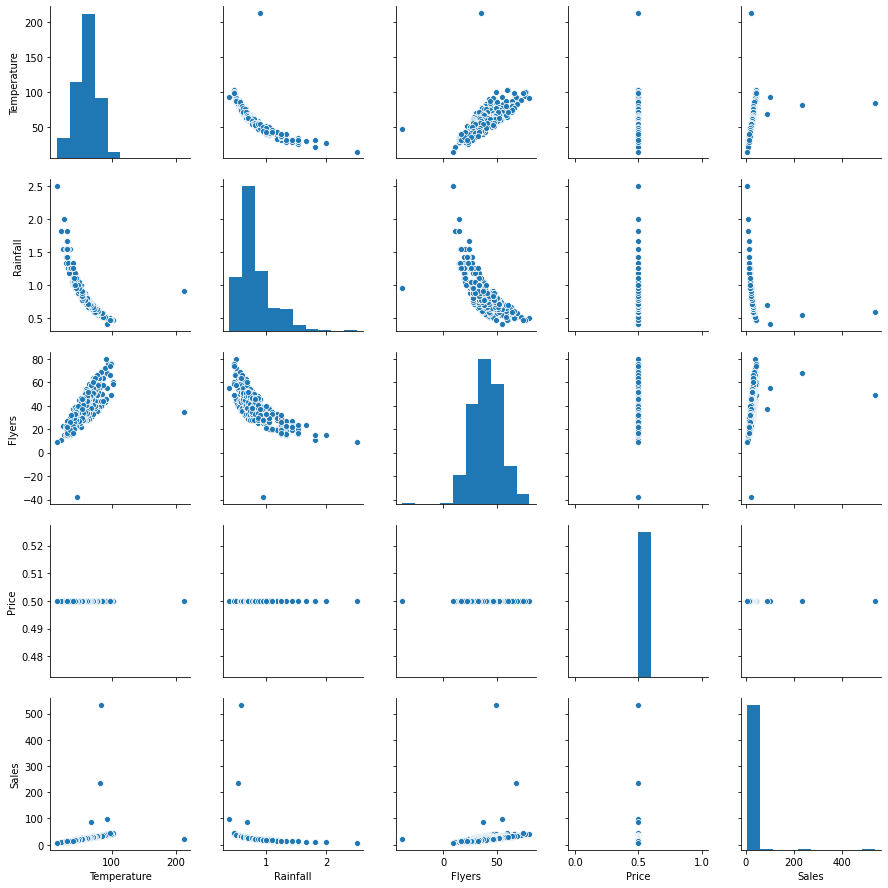

In [4]:
sns.pairplot(df)

Some key-takeaways:

* Flyers seems to be the only normally distributed features. All others are right skewed. 
* There are already some clear anomaloies that can be seen with scatterplots. 
* Some clearly wrong anomalies: 
    * There is a point that has temperature above 200 degrees... this is clearly not possible. 
    * There seems to be a point where over -40 fliers were handed out. While this could be a representation of the fliers being lost, it is also very odd. 
    * Even though price is constant, there are big spikes in sales. These could be related to a time factor, but seem odd. 

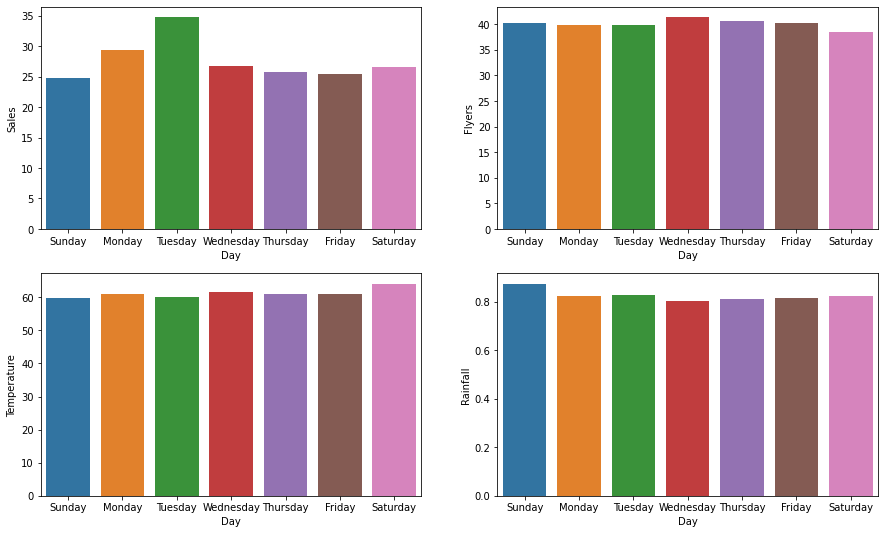

In [58]:
f = plt.figure(figsize=(15, 9))
f.add_subplot(2,2, 1)
sns.barplot(data=df, x="Day", y="Sales", ci=False)
f.add_subplot(2,2,2)
sns.barplot(data=df, x="Day", y="Flyers", ci=False)
f.add_subplot(2,2,3)
sns.barplot(data=df, x="Day", y="Temperature", ci=False)
f.add_subplot(2,2,4)
sns.barplot(data=df, x="Day", y="Rainfall", ci=False)

It seems that Tuesday's is, on average, when sales happen the most. We will need to see if theis is due to outliers.

### 1. Define a function named get_lower_and_upper_bounds that has two arguments. The first argument is a pandas Series. The second argument is the multiplier, which should have a default argument of 1.5.


In [5]:
def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    lower_bound = q1 - k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))
    
    
def get_lower_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    lower_bound = q1 - k * iqr
    return s.apply(lambda x: min([x - lower_bound, 0]))
    
def add_upper_lower_outlier_columns(df, k):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    # outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
    #                 for col in df.select_dtypes('number')}
    # return df.assign(**outlier_cols)

    for col in df.select_dtypes('number'):
        df[col + '_upper_outliers'] = get_upper_outliers(df[col], k)
        df[col + '_lower_outliers'] = get_lower_outliers(df[col], k)

    return df

### 2. Use the IQR Range Rule and the upper and lower bounds to identify the lower outliers of each column of lemonade.csv, using the multiplier of 1.5. Do these lower outliers make sense?Which outliers should be kept?

In [6]:
df_1 = add_upper_lower_outlier_columns(df, 1.5)

In [26]:
df.iloc[0:-1, 7:-1].sum()

Temperature_upper_outliers    107.30
Temperature_lower_outliers      0.00
Rainfall_upper_outliers         4.97
Rainfall_lower_outliers         0.00
Flyers_upper_outliers           5.00
Flyers_lower_outliers         -42.00
Price_upper_outliers            0.00
Price_lower_outliers            0.00
Sales_upper_outliers          775.00
dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

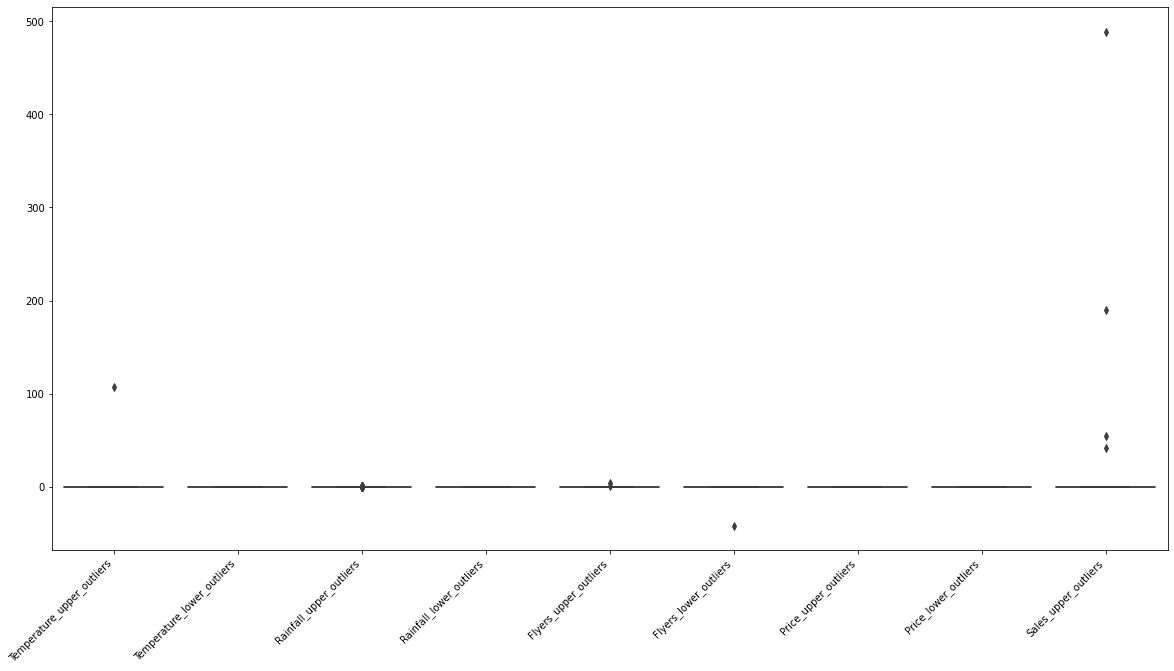

In [19]:
features = df.iloc[0:-1, 7:-1]
plt.figure(figsize=(20, 10))
sns.boxplot(data=features)
plt.xticks(rotation=45, ha="right")

In [23]:
col = "Temperature"
upper = df[col + "_upper_outliers"] > 0 
lower = df[col + "_lower_outliers"] < 0 

df[upper | lower]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_upper_outliers,Temperature_lower_outliers,Rainfall_upper_outliers,Rainfall_lower_outliers,Flyers_upper_outliers,Flyers_lower_outliers,Price_upper_outliers,Price_lower_outliers,Sales_upper_outliers,Sales_lower_outliers
41,2/11/17,Saturday,212.0,0.91,35,0.5,21,107.3,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0
364,12/31/17,Sunday,15.1,2.50,9,0.5,7,0.0,-1.6,1.2,0,0.0,0.0,0.0,0.0,0.0,0


There is a max temp of 212, which is not possible, and should be removed. The lower outlier, at 15, is not as improbably, as it was during dec (assuming the location is in the northern hemisphere). 

In [27]:
col = "Flyers"
upper = df[col + "_upper_outliers"] > 0 
lower = df[col + "_lower_outliers"] < 0 

df[upper | lower]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_upper_outliers,Temperature_lower_outliers,Rainfall_upper_outliers,Rainfall_lower_outliers,Flyers_upper_outliers,Flyers_lower_outliers,Price_upper_outliers,Price_lower_outliers,Sales_upper_outliers,Sales_lower_outliers
166,6/16/17,Friday,99.3,0.47,77,0.5,41,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0
194,7/14/17,Friday,92.0,0.50,80,0.5,40,0.0,0.0,0.0,0,4.0,0.0,0.0,0.0,0.0,0
324,11/21/17,Tuesday,47.0,0.95,-38,0.5,20,0.0,0.0,0.0,0,0.0,-42.0,0.0,0.0,0.0,0


We can keep the upper outliers, as they are not too far from the bound. The lower bound one, however, is odd, as it indicates that either 40 fliers we stolen or went missing. Since it is such a large discrepancy, we will remove it.

In [29]:
col = "Sales"
upper = df[col + "_upper_outliers"] > 0 
lower = df[col + "_lower_outliers"] < 0 

df[upper | lower]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_upper_outliers,Temperature_lower_outliers,Rainfall_upper_outliers,Rainfall_lower_outliers,Flyers_upper_outliers,Flyers_lower_outliers,Price_upper_outliers,Price_lower_outliers,Sales_upper_outliers,Sales_lower_outliers
183,7/3/17,Monday,81.5,0.54,68,0.5,235,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,190.0,0
184,7/4/17,Tuesday,84.2,0.59,49,0.5,534,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,489.0,0
185,7/5/17,Wednesday,93.0,0.40,55,0.5,99,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,54.0,0
258,9/16/17,Saturday,68.1,0.69,37,0.5,87,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,42.0,0


In [35]:
round(df.Sales.mean(), 2)

27.59

These are very strange outliers, and are all wabove 40 standard deviations from the top bound. I recommend removing these values, as it is difficult to beleve that customers were able to purchase close to $100 worth of lemonade. It is worth mentioning that the highest outlier (around $535) does happen on July 4th. You would expect a rise in sales during this period, as this is a national holiday and I suspect a lot of people would be more able (and willing) to purchase lemonade, however, the figure seems too high ever be realistic.

### 3. Using the multiplier of 3, IQR Range Rule, and the lower and upper bounds, identify the outliers above the upper_bound in each colum of lemonade.csv. Do these upper outliers make sense? Which outliers should be kept?

In [38]:
df = pd.read_csv("https://gist.githubusercontent.com/ryanorsinger/6af5008fa40071d8b0e064655c2886ef/raw/389449c3c96959e97e38f5b93d7d6e69d3455b6a/lemonade.csv")

In [39]:
df_1 = add_upper_lower_outlier_columns(df, 3)

In [46]:
df_1.iloc[0:-1, 7:-1].sum()

Temperature_upper_outliers     74.30
Temperature_lower_outliers      0.00
Rainfall_upper_outliers         0.57
Rainfall_lower_outliers         0.00
Flyers_upper_outliers           0.00
Flyers_lower_outliers         -15.00
Price_upper_outliers            0.00
Price_lower_outliers            0.00
Sales_upper_outliers          715.00
dtype: float64

In [47]:
col = "Temperature"
upper = df[col + "_upper_outliers"] > 0 
lower = df[col + "_lower_outliers"] < 0 

df[upper | lower]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_upper_outliers,Temperature_lower_outliers,Rainfall_upper_outliers,Rainfall_lower_outliers,Flyers_upper_outliers,Flyers_lower_outliers,Price_upper_outliers,Price_lower_outliers,Sales_upper_outliers,Sales_lower_outliers
41,2/11/17,Saturday,212.0,0.91,35,0.5,21,74.3,0,0.0,0,0,0.0,0.0,0.0,0.0,0


In this case - we still observe that the only outlier is when the temperature was over 200 degrees... in Feb. As initially stated, this one should be dropped.

In [48]:
col = "Flyers"
upper = df[col + "_upper_outliers"] > 0 
lower = df[col + "_lower_outliers"] < 0 

df[upper | lower]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_upper_outliers,Temperature_lower_outliers,Rainfall_upper_outliers,Rainfall_lower_outliers,Flyers_upper_outliers,Flyers_lower_outliers,Price_upper_outliers,Price_lower_outliers,Sales_upper_outliers,Sales_lower_outliers
324,11/21/17,Tuesday,47.0,0.95,-38,0.5,20,0.0,0,0.0,0,0,-15.0,0.0,0.0,0.0,0


Again - we see that the only extreme outlier is the one with over 40 missing flyers. We should remove it 

In [50]:
col = "Sales"
upper = df[col + "_upper_outliers"] > 0 
lower = df[col + "_lower_outliers"] < 0 

df[upper | lower]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_upper_outliers,Temperature_lower_outliers,Rainfall_upper_outliers,Rainfall_lower_outliers,Flyers_upper_outliers,Flyers_lower_outliers,Price_upper_outliers,Price_lower_outliers,Sales_upper_outliers,Sales_lower_outliers
183,7/3/17,Monday,81.5,0.54,68,0.5,235,0.0,0,0.0,0,0,0.0,0.0,0.0,175.0,0
184,7/4/17,Tuesday,84.2,0.59,49,0.5,534,0.0,0,0.0,0,0,0.0,0.0,0.0,474.0,0
185,7/5/17,Wednesday,93.0,0.40,55,0.5,99,0.0,0,0.0,0,0,0.0,0.0,0.0,39.0,0
258,9/16/17,Saturday,68.1,0.69,37,0.5,87,0.0,0,0.0,0,0,0.0,0.0,0.0,27.0,0


All four outliers are still being detected, as they are very much further away. I recommend we drop them.

In [51]:
col = "Rainfall"
upper = df[col + "_upper_outliers"] > 0 
lower = df[col + "_lower_outliers"] < 0 

df[upper | lower]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_upper_outliers,Temperature_lower_outliers,Rainfall_upper_outliers,Rainfall_lower_outliers,Flyers_upper_outliers,Flyers_lower_outliers,Price_upper_outliers,Price_lower_outliers,Sales_upper_outliers,Sales_lower_outliers
0,1/1/17,Sunday,27.0,2.00,15,0.5,10,0.0,0,0.31,0,0,0.0,0.0,0.0,0.0,0
338,12/5/17,Tuesday,22.0,1.82,11,0.5,10,0.0,0,0.13,0,0,0.0,0.0,0.0,0.0,0
343,12/10/17,Sunday,31.3,1.82,15,0.5,11,0.0,0,0.13,0,0,0.0,0.0,0.0,0.0,0
364,12/31/17,Sunday,15.1,2.50,9,0.5,7,0.0,0,0.81,0,0,0.0,0.0,0.0,0.0,0


These are not far enough to merit being dropped. There might be a correlation between temperature and rainfall that might help us explain if these outliers are within the range of improvable, but at this point I recommend we keep them. 

-------

### 1. Identify if any columns in lemonade.csv are normally distributed. For normally distributed columns:

In [74]:
# The only normally distributed feature is flyers

mean = df.Flyers.mean()

In [88]:
std = df.Flyers.std()

In [80]:
# How many points fall in the mean? 
(df.Flyers <= mean).mean()

0.5287671232876713

In [90]:
# How many points are 1 std away from the mean?

(df.Flyers <= (mean + std)).mean()

0.8438356164383561

In [93]:
# How many points are 2 std away from the mean?
(df.Flyers <= (mean + (std * 2))).mean()

0.9726027397260274

In [94]:
# How many points are 3 std away from the mean?
(df.Flyers <= (mean + (std * 3))).mean()

1.0